In [61]:
# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor



# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [66]:
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])
# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])


## Encoding

In [67]:
#CATEGÓRICAS: X24, X25, X30, RATE 

# X24 -> Factor ordenado (VLOW, LOW, MED, HIGH, VHIGH) -> LabelEncoder
# X25 -> Binario (YES, NO) -> LabelEncoder NO -> 0, YES -> 1. (Da un poco igual si es 0,1 o 1,2 la verdad)
# X30 -> ASKVR, CLPXZ, GXZVX, KUHMP, VTKGN, XNHTQ -> OneHotEncoder

# Ninguna presenta nulos, aplicamos las transformaciones y posteriormente imputación de NAs
# ------------------------------------------------------------------------------------------------------


df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])


# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

# df_train_encoded['X30'].astype(int)
# df_test_encoded['X30'].astype(int)

# #3. "OneHotEncoder" para X30

# one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int32)
# col_encoded = one_hot_encoder.fit_transform(df_train_num[["X30"]])
# df_train_encoded = pd.concat([df_train_num, pd.DataFrame(col_encoded, columns=one_hot_encoder.get_feature_names_out(['X30']))], axis=1)

# one_hot_encoder_test = OneHotEncoder(sparse=False, dtype=np.int32)
# col_encoded_test = one_hot_encoder_test.fit_transform(df_train_num[["X30"]]) # ponemos train porque test no tiene todas las distintas categorias
# df_test_encoded = pd.concat([df_test_num, pd.DataFrame(col_encoded_test, columns=one_hot_encoder_test.get_feature_names_out(['X30']))], axis=1)


# Eliminamos original
# df_train_encoded.head()
# df_test_encoded.head()

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30']) 

## Escalado del dataset

In [68]:
df_final_train = df_train_encoded.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train_encoded['ID'].copy()
train_RATE = df_train_encoded['RATE'].copy()
df_final_test = df_test_encoded.drop('ID', axis=1, inplace=False)
test_ID = df_test_encoded['ID'].copy()
scaler = RobustScaler()
df_scaled_train = scaler.fit_transform(df_final_train.to_numpy())
df_scaled_train = pd.DataFrame(df_scaled_train,index=df_final_train.index, columns=[
  df_final_train.columns])
df_scaled_test = scaler.transform(df_final_test.to_numpy())
df_scaled_test = pd.DataFrame(df_scaled_test,index=df_final_test.index, columns=[
  df_final_test.columns])

## Imputación valores

In [50]:
# Imputando con KNN (TRAIN)


Knn_imp_train = KNNImputer(n_neighbors=8).fit(df_scaled_train)
imputed_X_train = pd.DataFrame(Knn_imp_train.transform(df_scaled_train), columns=df_scaled_train.columns)

result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = df_train_encoded.columns
# vemos ratio de nulos ahora

In [60]:
# Imputando con la media
Mean_imp_train = SimpleImputer(strategy="mean")
Mean_imp_train.fit(df_scaled_train,train_RATE)
imputed_X_train = pd.DataFrame(Mean_imp_train.transform(df_scaled_train), columns=df_scaled_train.columns)

result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = df_train_encoded.columns

In [69]:
# Imputando con la moda
Mean_imp_train = SimpleImputer(strategy="most_frequent")
Mean_imp_train.fit(df_scaled_train,train_RATE)
imputed_X_train = pd.DataFrame(Mean_imp_train.transform(df_scaled_train), columns=df_scaled_train.columns)

result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = df_train_encoded.columns

In [ ]:
# Imputando con la mediana
Mean_imp_train = SimpleImputer(strategy="median")
Mean_imp_train.fit(df_scaled_train,train_RATE)
imputed_X_train = pd.DataFrame(Mean_imp_train.transform(df_scaled_train), columns=df_scaled_train.columns)

result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = df_train_encoded.columns

In [53]:
# Imputando con KNN (TEST)


Knn_imp_test = KNNImputer(n_neighbors=8).fit(df_scaled_test)
imputed_X_test = pd.DataFrame(Knn_imp_test.transform(df_scaled_test), columns=df_scaled_test.columns)

result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
result_df_test.columns = df_test_encoded.columns


In [52]:
# Imputando con la media (TEST)
imputed_X_test = pd.DataFrame(Mean_imp_train.transform(df_scaled_test), columns=df_scaled_test.columns)

result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
result_df_test.columns = df_test_encoded.columns


In [70]:
imputed_X_test = pd.DataFrame(Mean_imp_train.transform(df_scaled_test), columns=df_scaled_test.columns)

result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
result_df_test.columns = df_test_encoded.columns

## Seleccion de caracteristicas

In [78]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression(max_iter=100000)
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(result_df_train.iloc[:,1:40],result_df_train.iloc[:,40] )
rfecv.feature_names_in_

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 35


In [81]:
result_df_train.iloc[:,1:40].columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'],
      dtype='object')

In [80]:
print(rfecv.get_feature_names_out())

['X1' 'X2' 'X3' 'X5' 'X6' 'X7' 'X8' 'X9' 'X10' 'X12' 'X13' 'X14' 'X15'
 'X16' 'X17' 'X18' 'X19' 'X20' 'X21' 'X22' 'X23' 'X24' 'X25' 'X27' 'X28'
 'X29' 'X30' 'X32' 'X33' 'X34' 'X35' 'X36' 'X37' 'X38' 'X39']


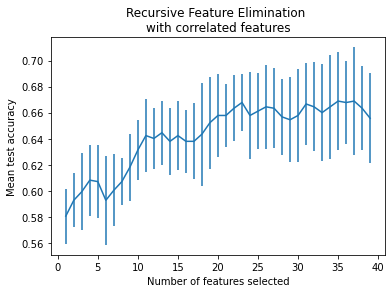

In [72]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [73]:
final_columns=rfecv.get_feature_names_out()
final_columns_train=np.append(np.array(["ID"]),final_columns)
final_columns_train=np.append(final_columns_train,np.array(["RATE"]))
final_columns_test=np.append(np.array(["ID"]),final_columns)
final_train=result_df_train.loc[:,final_columns_train]
final_test=result_df_test.loc[:,final_columns_test]

# Exportación de datos

In [74]:
result_df_train['X25'] = result_df_train['X25'].astype('int')
result_df_train['X30'] = result_df_train['X30'].astype('int')
result_df_test['X25'] = result_df_test['X25'].astype('int')
result_df_test['X30'] = result_df_test['X30'].astype('int')

In [75]:
final_train['X25'] = final_train['X25'].astype('int')
final_train['X30'] = final_train['X30'].astype('int')
final_test['X25'] = final_test['X25'].astype('int')
final_test['X30'] = final_test['X30'].astype('int')

In [76]:
result_df_train.to_csv('../data_preprocess/train_preprocess.csv', index=False)
result_df_test.to_csv('../data_preprocess/test_preprocess.csv', index=False)

In [77]:
final_train.to_csv('../data_preprocess/train_preprocess.csv', index=False)
final_test.to_csv('../data_preprocess/test_preprocess.csv', index=False)